<center><h1>Selective Search</h1></center>
<h2>1. Introduction</h2>
Before doing recognition and meter/pointer reading, we need to locate the region of the gauge showing in a picture. Then we could zoom in to that region for further processing and classification. Since in a picture there could be many objects, the machine is not constrained to clip out a region with the very single targeted object (or not possible). As an alternative, the machine is able to propose multiple regions with different objects (maybe just background). And this step is usually called region proposal. With these proposed regions, we could use classifiers, such as SVM, CNN to detect which region has the targeted object.

There are many ways to do region proposal. In recent years, with the convolutional neural network becoming easier to build and tune, researchers could build NN aimed for region proposal. However that needs great amount of labeled data. Before the era of CNN, people usually use pure image processing techniques to propose regions. And here we are experimenting with one of them: selective search.

In this notebook, we inherited code from https://github.com/AlpacaDB/selectivesearch and modified the code to adapt the binary images. This method seems working with a non-ideal sample image and we could further classify the regions with a trained SVM to detect which region has the gauge.

<h2>2. Features</h2>
There are a few features we need to use to compare similarities between segments. The way we compute segments is also described below. The similarities are compared based on the histogram of the features. So after the features computed, histogram will also be generated for each segment.
[<h3>2.1. Segments</h3>](#segments)
[<h3>2.2. Textures</h3>](#textures)
[<h3>2.3. Colors (optional)</h3>](#colors)

[<h2>3. Workflow</h2>](#selective_search)

In [72]:
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy as np
import numpy

from scipy import ndimage as ndi

from matplotlib import pyplot as plt
import matplotlib.patches as patches

<a id="segments"></a>
<h3>2.1. Segments</h3>
This step is doing segmentation of the images purely based on pixel values. The algorithm used is called Felzenswalb and Huttenlocher Algorithm, which segments the smallest regions of the image. And then these segments will be grouped to form up larger segments when similar features are found betweens pairs of segments.

In [141]:
def _generate_segments(im_orig, scale, sigma, min_size, gray=False):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """
    
    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)
    
    if gray:
        # merged mask channel to the image as a 2nd channel if image is grayscale
        im_orig = numpy.dstack((im_orig, im_mask))
        
    else:
        # merge mask channel to the image as a 4th channel
        im_orig = np.append(
            im_orig, np.zeros(im_orig.shape[:2])[:, :, np.newaxis], axis=2)
        im_orig[:, :, 3] = im_mask

    return im_orig

In [142]:
def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])

In [143]:
def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])

In [144]:
def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize

In [145]:
def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize

In [146]:
def _calc_sim(r1, r2, imsize, gray=False):
    if gray:
        return (_sim_texture(r1, r2) + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))

<a id="colors"></a>
<h3>2.3. Colors (optional)</h3>
Other than textures, when we have grayscale images or three-channel (RGB) images, it is also common to compare the combination of the [color histograms](#color_hist) of the three channels.
<a id="color_hist"></a>

In [147]:
def _calc_colour_hist(img):
    """
        calculate colour histogram for each region
        the size of output histogram will be BINS * COLOUR_CHANNELS(3)
        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
        extract HSV
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist

<a id='textures'></a>
<h3>2.2. Textures</h3>
The definition of image textures can be found from the [Wikipedia](https://en.wikipedia.org/wiki/Image_texture) page. What we need to do is first calculate the [texture gradient](#texture_gradient) (in this application we are using local binary pattern) of the image and then calculate the [texture histogram](#texture_hist).
<a id='texture_gradient'></a>

In [148]:
def _calc_texture_gradient(img, gray=False):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    
    if gray:
        ret = skimage.feature.local_binary_pattern(img[:, :, 0], 8, 1.0)
    else:
        for colour_channel in (0, 1, 2):
            ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
                img[:, :, colour_channel], 8, 1.0)
    return ret

<a id="texture_hist"></a>

In [191]:
def _calc_texture_hist(img, gray=False):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = np.array([])
    
    if gray:
        fd = img
        # Calculate histogram
        hist = np.concatenate([hist] + [np.histogram(fd, BINS, (0.0, 1.0))[0]])
        
    else:
        for colour_channel in (0, 1, 2):

            # mask by the colour channel
            fd = img[:, colour_channel]

            # calculate histogram for each orientation and concatenate them all
            # and join to the result
            hist = np.concatenate(
                [hist] + [np.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist

In [192]:
def _extract_regions(img, gray=False):

    R = {}

    # get hsv image
    if not gray:
        hsv = skimage.color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):
        if gray:
            for x, (g, l) in enumerate(i):
                # initialize a new region
                if l not in R:
                    R[l] = {
                        "min_x": 0xffff, "min_y": 0xffff,
                        "max_x": 0, "max_y": 0, "labels": [l]
                    }
                
                # adjust bounding box
                if R[l]["min_x"] > x:
                    R[l]["min_x"] = x
                if R[l]["min_y"] > y:
                    R[l]["min_y"] = y
                if R[l]["max_x"] < x:
                    R[l]["max_x"] = x
                if R[l]["max_y"] < y:
                    R[l]["max_y"] = y
        
        else:
            for x, (r, g, b, l) in enumerate(i):

                # initialize a new region
                if l not in R:
                    R[l] = {
                        "min_x": 0xffff, "min_y": 0xffff,
                        "max_x": 0, "max_y": 0, "labels": [l]}

                # bounding box
                if R[l]["min_x"] > x:
                    R[l]["min_x"] = x
                if R[l]["min_y"] > y:
                    R[l]["min_y"] = y
                if R[l]["max_x"] < x:
                    R[l]["max_x"] = x
                if R[l]["max_y"] < y:
                    R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img, gray=gray)

    # pass 3: calculate colour histogram of each region
    for k, v in R.items():
        if gray:
            # Calculate the size of the region
            R[k]["size"] = len(img[:, :, :][img[:, :, 1]==k])
            
            # We do not need to calculate colour histogram because it is binary
            # Calculate texture histogram
            R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 1]==k], gray=gray)
        else:
            # colour histogram
            masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
            R[k]["size"] = len(masked_pixels / 4)
            R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

            # texture histogram
            R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R

In [152]:
def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = regions.items()
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours

In [153]:
def _merge_regions(r1, r2, gray=False):
    new_size = r1["size"] + r2["size"]
    if gray:
        rt = {
            "min_x": min(r1["min_x"], r2["min_x"]),
            "min_y": min(r1["min_y"], r2["min_y"]),
            "max_x": max(r1["max_x"], r2["max_x"]),
            "max_y": max(r1["max_y"], r2["max_y"]),
            "size": new_size,
            "hist_t": (
                r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
            "labels": r1["labels"] + r2["labels"]
        }
    else:
        rt = {
            "min_x": min(r1["min_x"], r2["min_x"]),
            "min_y": min(r1["min_y"], r2["min_y"]),
            "max_x": max(r1["max_x"], r2["max_x"]),
            "max_y": max(r1["max_y"], r2["max_y"]),
            "size": new_size,
            "hist_c": (
                r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
            "hist_t": (
                r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
            "labels": r1["labels"] + r2["labels"]
        }
    return rt

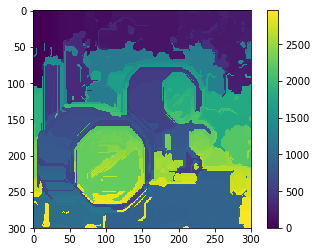

In [187]:
img = ndi.imread("data/sample_1.png")
img = skimage.transform.resize(img, (300, 300, 3))
img = _generate_segments(img, scale=10.0, sigma=2.5, min_size=8)
plt.imshow(img[:, :, -1])
plt.colorbar()
plt.show()

In [193]:
imsize = img.shape[0] * img.shape[1]
R = _extract_regions(img)
neighbours = _extract_neighbours(R)

In [103]:
S = {}
for (ai, ar), (bi, br) in neighbours:
    S[(ai, bi)] = _calc_sim(ar, br, imsize)
    
orig_regions_max = max(R.keys())
    
while S != {}:

    # get highest similarity
    i, j = sorted(S.items(), cmp=lambda a, b: cmp(a[1], b[1]))[-1][0]

    # merge corresponding regions
    t = max(R.keys()) + 1.0
    R[t] = _merge_regions(R[i], R[j])

    # mark similarities for regions to be removed
    key_to_delete = []
    for k, v in S.items():
        if (i in k) or (j in k):
            key_to_delete.append(k)

    # remove old similarities of related regions
    for k in key_to_delete:
        del S[k]

    # calculate similarity set with the new region
    for k in filter(lambda a: a != (i, j), key_to_delete):
        n = k[1] if k[0] in (i, j) else k[0]
        S[(t, n)] = _calc_sim(R[t], R[n], imsize)
        
regions = []
for k, r in R.items():
    if k > orig_regions_max_label and r['size'] > 1000 and r['size'] < 10000:
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

In [280]:
def test_img(bool_img, gray=False, scale=18., sigma=3.5, min_size=12):
    plt.imshow(bool_img)
    plt.colorbar()
    plt.show()
    bool_img = _generate_segments(bool_img, scale=scale, sigma=sigma, min_size=min_size, gray=gray)
    plt.imshow(bool_img[:, :, -1])
    plt.show()

    imsize = bool_img.shape[0] * bool_img.shape[1]
    R = _extract_regions(bool_img, gray=gray)
    neighbours = _extract_neighbours(R)

    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize, gray=gray) 

    orig_regions_max = max(R.keys())

    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), cmp=lambda a, b: cmp(a[1], b[1]))[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0

        R[t] = _merge_regions(R[i], R[j], gray=gray)

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in S.items():
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in filter(lambda a: a != (i, j), key_to_delete):
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize, gray=gray)

    regions = []
    for k, r in R.items():
        if k > orig_regions_max and r['size'] > 1000 and r['size'] < 10000:
            regions.append({
                'rect': (
                    r['min_x'], r['min_y'],
                    r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
                'size': r['size'],
                'labels': r['labels']
            })

    plot_regions(img, regions)

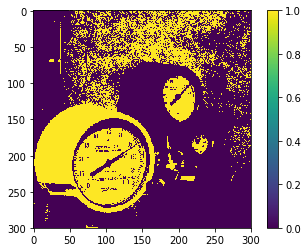

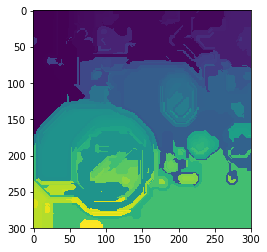

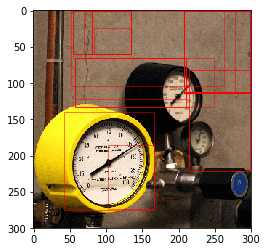

In [281]:
bool_img = skimage.util.img_as_float(skimage.util.img_as_bool(skimage.color.rgb2gray(img[:, :, :3])))
test_img(bool_img, gray=True, scale=30., sigma=4., min_size=8)

<a id="selective_search"></a>
<h2>3. Workflow</h2>
The workflow of selective search composed of gathering these features mentioned above and iteratively merging similar neighboring segments based on their features and overlapped areas.

<h3>3.1. Initialization</h3>
<p>Given an image, the first thing needs to be done is segmenting the smallest regions of the image. _Smallest_ is a relative concept which is controllable and will be defined as the `scale` parameter in the segmentation algorithm. In our case we could make it large as we know the meter is going to cover most of the area of the image.<p/>

<p>Then you extract these segments and compiled them into `dict` and also extract neighbors of any pair of segments. The neighbor is defined as the rectangular regions of two segments has overlapped area. And the initial similarities of all pairs of neighbors are calculated based on their textures, colors and overlapped areas.</p>

<h3>3.2. Iterative merging</h3>
<p>For each loop of iterations, first we need to sort all the neighbors by its similarities from the highest to the lowest, then we merge the top similar neighbors and remove their original objects in the segments set and recalculate the similarities of the new region to the originals. The iterations will end when the neighbor pairs set becomes empty.</p>

In [1]:
def selective_search(
        im_orig, scale=1.0, sigma=0.8, min_size=50, gray=False):
    '''Selective Search
    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, right, bottom),
                    'labels': [...]
                },
                ...
            ]
    '''
#     assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size, gray=gray)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    R = _extract_regions(img, gray=gray)

    # extract neighbouring information
    neighbours = _extract_neighbours(R)

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize, gray=gray)

    # hierarchal search
    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), cmp=lambda a, b: cmp(a[1], b[1]))[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j], gray=gray)

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in S.items():
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in filter(lambda a: a != (i, j), key_to_delete):
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize, gray=gray)

    regions = []
    for k, r in R.items():
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions

In [155]:
def plot_regions(img, regions):
    fig,ax = plt.subplots(1)
    ax.imshow(img[:, :, :-1])
    for i, r in enumerate(regions):
        rect = patches.Rectangle((r['rect'][0], r['rect'][1]), r['rect'][2], r['rect'][3],
                                 linewidth=0.5,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()